In [1]:
# enable logging widget
%load_ext pymor.discretizers.builtin.gui.jupyter

from IPython.display import Image, display

The pymor.discretizers.builtin.gui.jupyter module is not an IPython extension.


# Reduced Basis Methods with pyMOR

## Our Goal

We want to do model order reduction (MOR) for *parametric problems*.

This means:

- We are given a full-order model (FOM), usually a PDE model, which depends on some set of parameters $\mu \in\mathcal{P}\subset \mathbb{R}^Q$.
- We can simulate/solve the FOM for any given parameter $\mu\in\mathcal{P}$. But this is costly.
- We want to simulate the model for many different $\mu$.

**Task:**

- Replace the FOM by a surrogate reduced-order model (ROM).
- The ROM should be much faster to simulate/solve.
- The error between the ROM and FOM solution should be small and controllable.

Note: In this tutorial we will only cover the mere basics of reduced basis (RB) methods. The approach has been extended to other types of models (systems, non-linear, inf-sup stable, outputs, ...) and is largely independent of the specific choice of discretization method.

### Example of FOM and ROM in a multi-query scenario

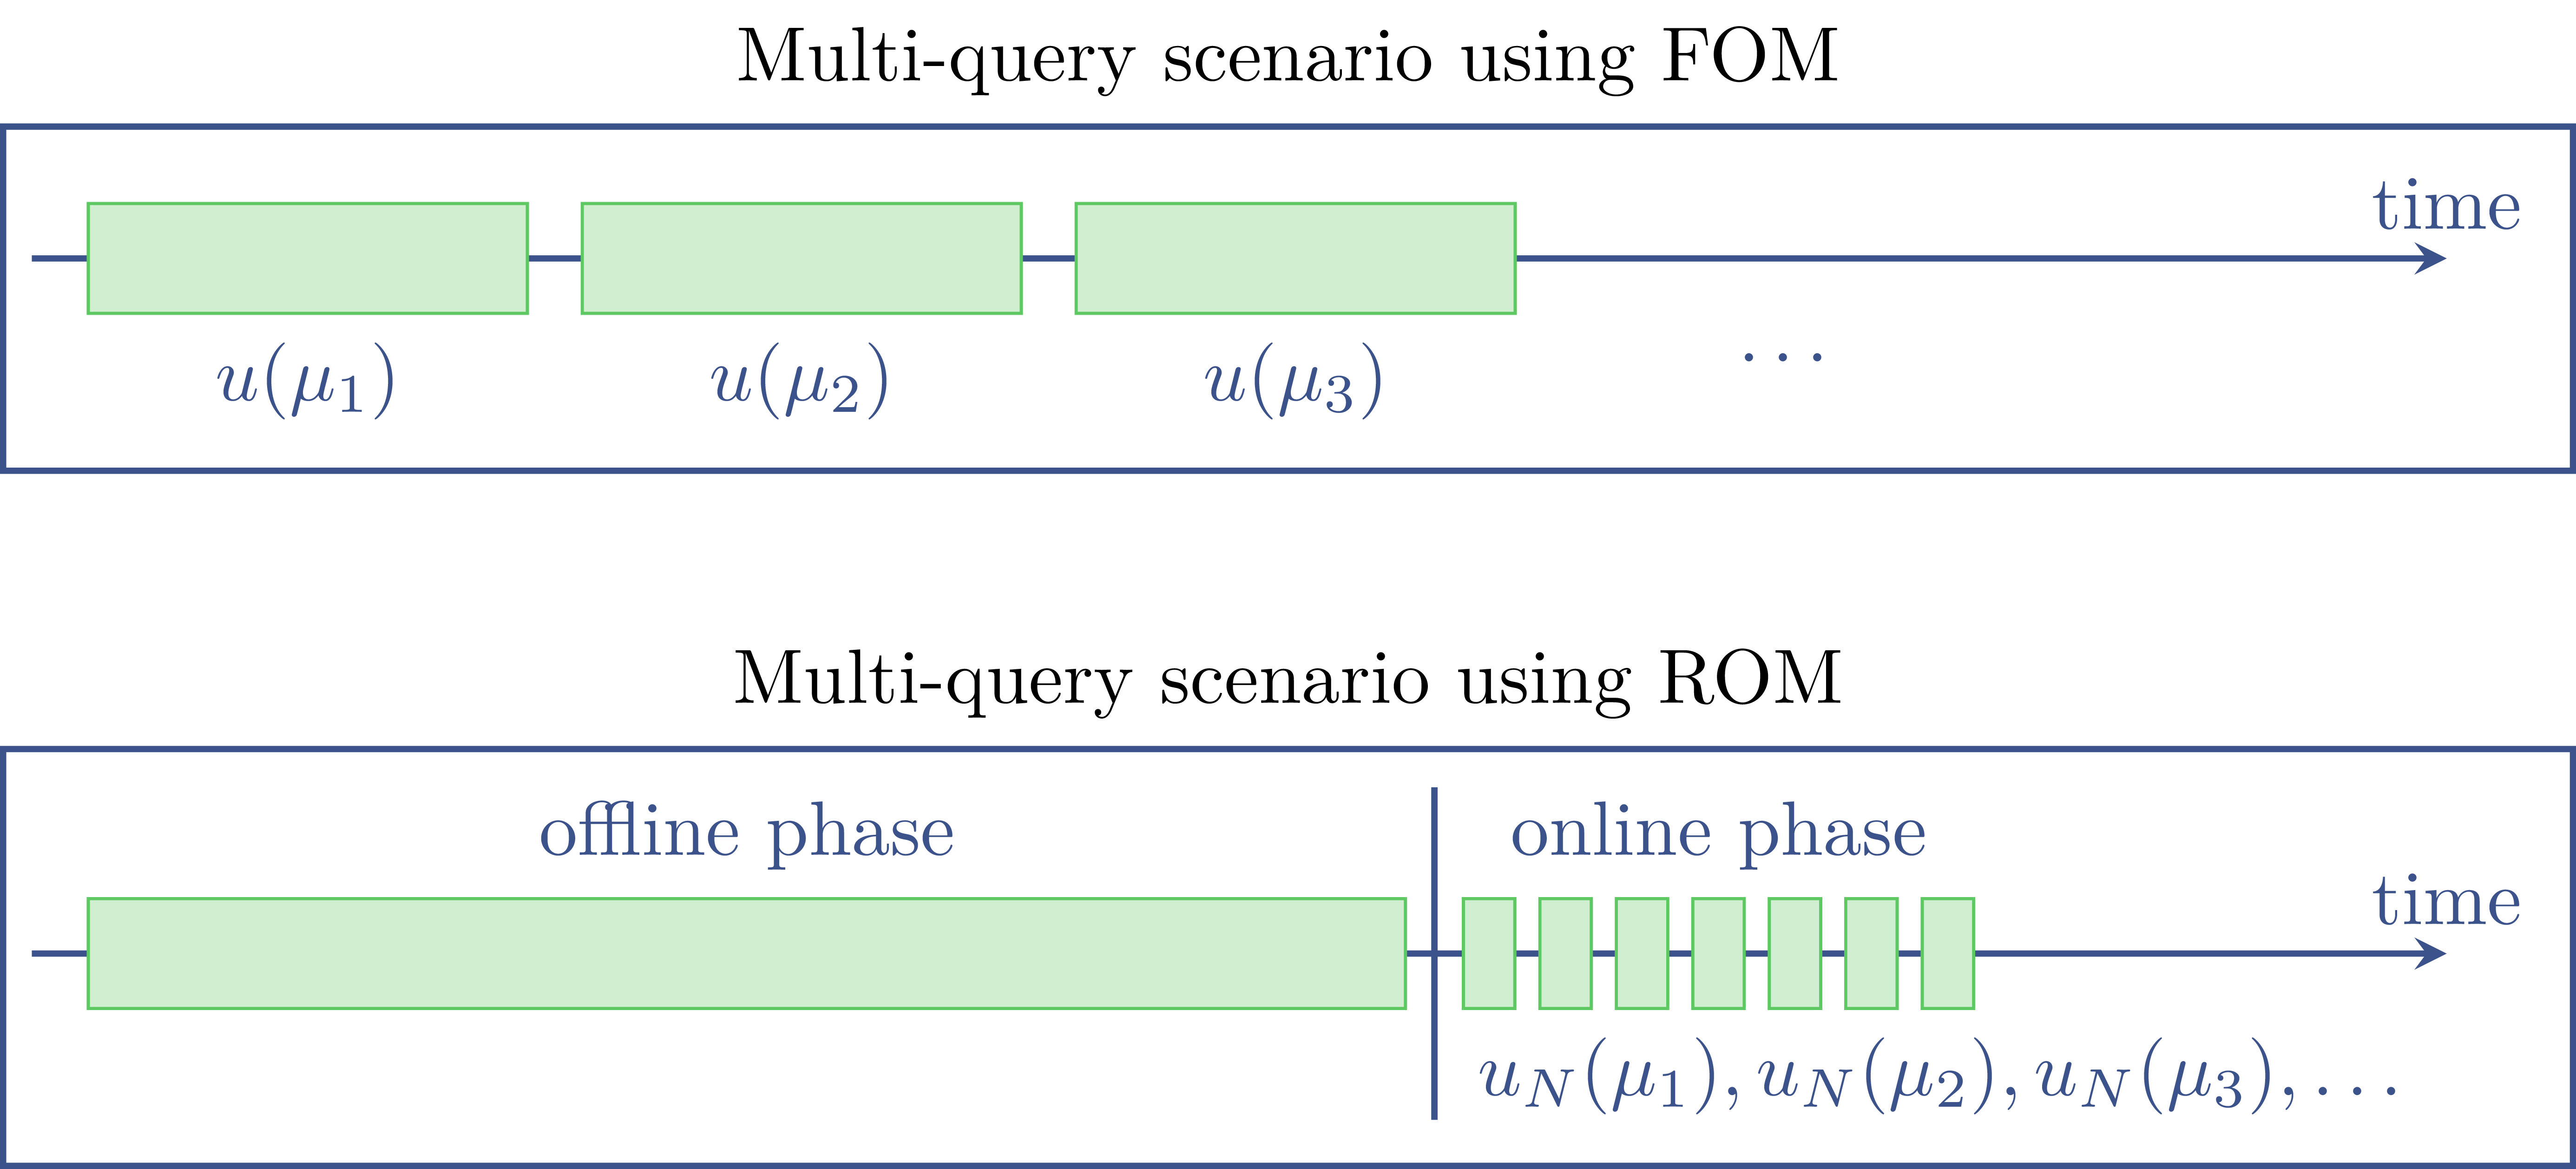

In [2]:
Image(filename="figures/multi_query.png", width=600)

## Building the FOM

### Thermal-block problem

Find $u(x,\mu)$ for $\mu\in\mathcal{P}$ such that

$$
\begin{align*}
-\nabla \cdot [d(x, \mu) \nabla u(x,\mu)] &= f(x) & x &\in \Omega, \\
u(x,\mu) &= 0 & x &\in \partial \Omega,
\end{align*}
$$

where $\Omega := [0,1]^2 = \Omega_1 \cup \Omega_2 \cup \Omega_3 \cup \Omega_4$, $f \in L^2(\Omega)$, $f(x)=1$ for all $x\in\mathbb{R}$,


$$
d(x, \mu) \equiv \mu_i \quad x \in \Omega_i
$$

and $\mu \in [\mu_{\min}, \mu_{\max}]^4$.


```
        (0,1)-----------------(1,1)
        |            |            |
        |            |            |
        |     μ_2    |     μ_3    |
        |            |            |
        |            |            |
        |--------------------------
        |            |            |
        |            |            |
        |     μ_0    |     μ_1    |
        |            |            |
        |            |            |
        (0,0)-----------------(1,0)
```

### Setting up an analytical description of the thermal block problem

The thermal block problem already comes with pyMOR:

In [6]:
from pymor.basic import *
p = thermal_block_problem([2,2])

Our problem is parameterized:

In [7]:
p.parameters

Parameters({diffusion: 4})

### Looking at the definition

We can easily look at the definition of `p` by printing its `repr`:

In [8]:
p

StationaryProblem(
    RectDomain(domain=array([[0, 0], [1, 1]])),
    rhs=ConstantFunction(dim_domain=2),
    diffusion=LincombFunction(
                  (ExpressionFunction(
                       '(ix * dx <= x[0] < (ix + 1) * dx) * (iy * dy <= x[1] < (iy + 1) * dy) * 1.',
                       dim_domain=2,
                       values={ix: 0, iy: 0, dx: 0.5, dy: 0.5},
                       name='diffusion_0_0'),
                   ExpressionFunction(
                       '(x[0] >= ix * dx) * (iy * dy <= x[1] < (iy + 1) * dy) * 1.',
                       dim_domain=2,
                       values={ix: 1, iy: 0, dx: 0.5, dy: 0.5},
                       name='diffusion_1_0'),
                   ExpressionFunction(
                       '(ix * dx <= x[0] < (ix + 1) * dx) * (x[1] >= iy * dy) * 1.',
                       dim_domain=2,
                       values={ix: 0, iy: 1, dx: 0.5, dy: 0.5},
                       name='diffusion_0_1'),
                   ExpressionFunc

It is easy to [build custom problem definitions](https://docs.pymor.org/latest/tutorial_builtin_discretizer.html).

### Weak formulation

Find $u(\mu) \in H^1_0(\Omega)$ such that

$$
\underbrace{\int_\Omega d(x, \mu(x)) \nabla u(x, \mu) \cdot \nabla v(x) \,dx}
    _{=:a(u(\mu), v; \mu)}
= \underbrace{\int_\Omega f(x)v(x) \,dx}
    _{=:\ell(v)}
    \qquad \forall v \in H^1_0(\Omega).
$$

### Galerkin projection onto finite-element space

Let $\mathcal{T}_h$ be an admissible triangulation of $\Omega$ and $V_h:=\mathcal{S}_{h,0}^1(\mathcal{T}_h)$ the corresponding space of piece-wise linear finite-element functions over $\mathcal{T}_h$ which vanish at $\partial\Omega$.
The finite-element approximation $u_h(\mu) \in V_h$ is then given by


$$
    a(u_h(\mu), v_h;\mu) = \ell(v_h)
    \qquad \forall v_h \in V_h.
$$

Céa's Lemma states that $u_h(\mu)$ is a quasi-best approximation of $u(\mu)$ in $V_h$:

$$
    \|\nabla u(\mu) - \nabla u_h(\mu)\|_{L^2(\Omega)}
    \leq \frac{\mu_{max}}{\mu_{min}} \inf_{v_h \in V_h} \|\nabla u(\mu) - \nabla v_h\|_{L^2(\Omega)}.
$$

### Linear system assembly

Let $\varphi_{h,1}, \ldots, \varphi_{h,n}$ be the finite-element basis of $\mathcal{S}_{h,0}^1(\mathcal{T}_h)$.
Let $A(\mu) \in \mathbb{R}^{n\times n}$, $\underline{\ell} \in \mathbb{R}^n$ be given by

$$
    A(\mu)_{j,i} := a(\varphi_{h,i}, \varphi_{h,j};\mu) \qquad
    \underline \ell_j := \ell(\varphi_{h,j}).
$$

Then with
$$
    u_h(\mu) = \sum_{i=1}^{n} \underline{u}_h(\mu)_i \cdot \varphi_{h,i},
$$

we get

$$
    A(\mu) \cdot \underline{u}_h(\mu) = \underline{\ell}.
$$

Note that $A(\mu)$ is a sparse matrix.

### FOM assembly with pyMOR

We use the builtin discretizer `discretize_stationary_cg` to compute a finite-element discretization of the problem:

In [9]:
fom, data = discretize_stationary_cg(p, diameter=1/100)

50:16 DiffusionOperatorP1: Calculate gradients of shape functions transformed by reference map ...
50:16 DiffusionOperatorP1: Calculate all local scalar products between gradients ...
50:16 DiffusionOperatorP1: Determine global dofs ...
50:16 DiffusionOperatorP1: Boundary treatment ...
50:16 DiffusionOperatorP1: Assemble system matrix ...
50:16 DiffusionOperatorP1: Calculate gradients of shape functions transformed by reference map ...
50:16 DiffusionOperatorP1: Calculate all local scalar products between gradients ...
50:16 DiffusionOperatorP1: Determine global dofs ...
50:16 DiffusionOperatorP1: Boundary treatment ...
50:16 DiffusionOperatorP1: Assemble system matrix ...
50:16 DiffusionOperatorP1: Calculate gradients of shape functions transformed by reference map ...
50:16 DiffusionOperatorP1: Calculate all local scalar products between gradients ...
50:16 DiffusionOperatorP1: Determine global dofs ...
50:16 DiffusionOperatorP1: Boundary treatment ...
50:16 DiffusionOperatorP1: Asse

`fom` is a `Model`. It has the same `Parameters` as `p`:

In [10]:
fom.parameters

Parameters({diffusion: 4})

### Solving the FOM

To `solve` the FOM, we need to specify values for those parameters:

In [11]:
U = fom.solve({'diffusion': [1., 0.01, 0.1, 1]})

50:34 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [1.0, 0.01, 0.1, 1.0], input: } ...


`U` is a `VectorArray`, an ordered collection of vectors of the same dimension:

In [12]:
U

NumpyVectorArray(
    NumpyVectorSpace(20201, id='STATE'),
    [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.57846167e-04
      2.33508510e-04 8.79461711e-05]],
    _len=1)

`U` only contains a single vector:

In [ ]:
len(U)

For a time-dependent problem, `U` would have contained a time-series of vectors. `U` corresponds to the coefficient vector $\underline{u}_h(\mu)$.

### Looking at the solution

We can use the `visualize` method to plot the solution:

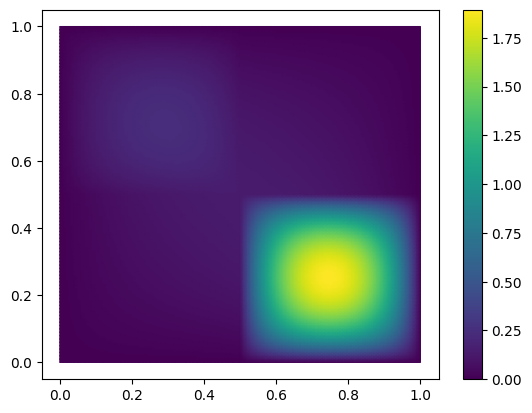

In [13]:
fom.visualize(U)

### Parameter separability

Remember the special form of $a(\cdot, \cdot; \mu)$:

$$
\begin{align}
    a(u, v; \mu) &:= \int_\Omega d(x, \mu) \nabla u(x) \cdot \nabla v(x) \,dx \\
    &:=\int_\Omega \Bigl(\sum_{q=1}^Q \mu_q \mathbb{1}_q(x)\Bigr) \nabla u(x) \cdot \nabla v(x) \,dx \\
    &:=\sum_{q=1}^Q  \ \underbrace{\mu_q}_{:=\theta_q(\mu)} \ \ 
        \underbrace{\int_\Omega \mathbb{1}_q(x) \nabla u(x) \cdot \nabla v(x) \,dx}_{=:a_q(u,v)}.
\end{align}
$$

> Hence, $a(\cdot, \cdot; \mu)$ admits the **affine decomposition**
>
>$$
    a(u, v; \mu) = \sum_{q=1}^Q \theta_q(\mu) \cdot a_q(u,v).
$$
>
>Consequently, for $A(\mu)$ we have the same structure:
>
>$$
    A(\mu) = \sum_{q=1}^Q \theta_q(\mu) \cdot A_q,
$$
>
> where $(A_q)_{j,i} := a_q(\varphi_{h,i}, \varphi_{h,j})$.

### Parameter-separable FOM

Remember that our problem definition encoded the affine decomposition of $d(x, \mu)$ using a `LincombFunction`:

In [14]:
p.diffusion

LincombFunction(
    (ExpressionFunction(
         '(ix * dx <= x[0] < (ix + 1) * dx) * (iy * dy <= x[1] < (iy + 1) * dy) * 1.',
         dim_domain=2,
         values={ix: 0, iy: 0, dx: 0.5, dy: 0.5},
         name='diffusion_0_0'),
     ExpressionFunction(
         '(x[0] >= ix * dx) * (iy * dy <= x[1] < (iy + 1) * dy) * 1.',
         dim_domain=2,
         values={ix: 1, iy: 0, dx: 0.5, dy: 0.5},
         name='diffusion_1_0'),
     ExpressionFunction(
         '(ix * dx <= x[0] < (ix + 1) * dx) * (x[1] >= iy * dy) * 1.',
         dim_domain=2,
         values={ix: 0, iy: 1, dx: 0.5, dy: 0.5},
         name='diffusion_0_1'),
     ExpressionFunction(
         '(x[0] >= ix * dx) * (x[1] >= iy * dy) * 1.',
         dim_domain=2,
         values={ix: 1, iy: 1, dx: 0.5, dy: 0.5},
         name='diffusion_1_1')),
    (ProjectionParameterFunctional('diffusion', size=4, index=0, name='diffusion_0_0'),
     ProjectionParameterFunctional('diffusion', size=4, index=1, name='diffusion_1_0'),
  

pyMOR's builtin `discretizer` automatically preserves this structure when assembling the system matrices. Let's look at the `fom` in more detail. The system matrix $A(\mu)$ is stored in the `Model`'s `operator` attribute:

In [ ]:
fom.operator

We see that the `LincombFunction` has become a `LincombOperator` of `NumpyMatrixOperators`.
pyMOR always interprets matrices as linear `Operators`.

The right-hand side vector $\underline{\ell}$ is stored in the `rhs` attribute:

In [ ]:
fom.rhs

`fom.rhs` is not a `VectorArray` but a vector-like operator in order to support parameter-dependent right-hand sides. Only `Operators` can depend on a parameter in `pyMOR`, not `VectorArrays`.

### Other ways of obtaining the FOM

> Using an `analyticalproblem` and a `discretizer` is just one way
  to build the FOM.
>  
> Everything that follows works the same for a FOM that is built using an external PDE solver.

## VectorArrays

### Some words about VectorArrays

Each `VectorArray` has a length, i.e, the number of vectors in the array:

In [ ]:
len(U)

> There is not the notion of a single vector in pyMOR! Don't try to get hold of one!

Its dimension is the *uniform* size of each vector in the array:

In [ ]:
U.dim

When using pyMOR's builtin discretizations, we use `NumpyVectorArrays`:

In [ ]:
type(U)

These arrays internally store their vectors using a 2d `NumPy` array:

In [ ]:
U.impl._array

When using an external PDE solver for the FOM, we usually use `ListVectorArrays`, which manage a Python list of vector objects that directly correspond to vector data in the PDE solvers memory.

### Supported Operations

|                  |                                                         |
| :-               | :-                                                      |
| `append`         | append vectors from another array                       |
| `+`/`-`/`*`      | element-wise addition/subtraction/scalar multiplication |
| `inner`          | matrix of inner products between all vectors            |
| `pairwise_inner` | list of pairwise inner products                         |
| `norm`           | list of norms                                           |
| `lincomb`        | linear combination of the vectors in the array          |
| `scal`           | in-place scalar multiplication                          |
| `axpy`           | in-place BLAS axpy operation                            |
| `dofs`           | return a few degrees of freedom as NumPy array          |

### Playing a bit with VectorArrays

It is important to note that `VectorArrays` are never instantiated directly. All `VectorArrays` are created by their `VectorSpace`:

In [ ]:
V = fom.solution_space.empty()

Let's accumulate some solutions:

In [ ]:
for mu in p.parameter_space.sample_randomly(10):
    V.append(fom.solve(mu))

Indeed, `V` now contains 10 vectors:

In [ ]:
len(V)

We can visualize all the solutions as a time series:

In [ ]:
fom.visualize(V)

## Reduced basis methods

### Projection-based MOR

Going back to the definition of the FOM

$$
    a(u_h(\mu), v; \mu) = \ell(v_h) \qquad \forall v_h \in V_h,
$$

our MOR approach is based on the idea of replacing the generic finite-element space $V_h$ by a problem-adapted reduced space $V_N$ of low dimension. I.e., we simply define our ROM by a Galerkin projection of the solution onto the reduced space $V_N$. So the reduced approximation $u_N(\mu) \in V_N$ of $u_h(\mu)\in V_h$ is given as the solution of

$$
    a(u_N(\mu), v_N; \mu) = \ell(v_N) \qquad \forall v_N \in V_N.
$$

Again, we can apply Céa's Lemma:

$$
    \|\nabla u_h(\mu) - \nabla u_N(\mu)\|_{L^2(\Omega)}
    \leq \frac{\mu_{max}}{\mu_{min}} \inf_{\color{red}v_N \in V_N} \|\nabla u_h(\mu) - \nabla v_N\|_{L^2(\Omega)}.
$$

### Does a good reduced space $V_N$ exist?

Thanks to Céa's lemma, our only job is to come up with a good low-dimensional approximation space $V_N$. In RB methods, our definition of 'good' is usually that we want to miminize the worst-case best-approximation error over all parameters $\mu \in \mathcal{P}$. I.e.,

$$
    \sup_{\mu \in \mathcal{P}} \inf_{v_N \in V_N} \|\nabla u_h(\mu) - \nabla v_N\|_{L^2(\Omega)}
$$

should not be much larger than the Kolmogorov $N$-width

$$
    d_N:=\inf_{\substack{V'_N \subset V_h\\ \dim V'_N \leq N}}\sup_{\mu \in \mathcal{P}} \inf_{v'_N \in V'_N} \|\nabla u_h(\mu) - \nabla v'_N\|_{L^2(\Omega)}.
$$

We won't go into details here, but it can be shown that for parameter-separable coercive problems like the thermal-block problem, the Kolmogorov $N$-widths decay at a subexponential rate, so good reduced spaces $V_N$ of small dimension $N$ do exist.

### Snapshot-based MOR

The question remains how to find a good $V_N$ algorithmically. RB methods are snapshot based which means that $V_N$ is constructed from 'solution snapshots' $u_{h}(\mu_i)$ of the FOM, i.e.

$$
    V_N := \operatorname{span} \{u_h(\mu_1), \ldots, u_h(\mu_N)\}.
$$

We will start by just randomly picking some snapshot parameters $\mu_i\in\mathcal{P}$:

In [15]:
snapshot_parameters = p.parameter_space.sample_randomly(10)
snapshots = fom.solution_space.empty()
for mu in snapshot_parameters:
    snapshots.append(fom.solve(mu))

01:06:54 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.796560443700367, 0.4949905957768471, 0.8727381279202442, 0.7276312261534275], input: } ...
01:06:55 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.18475961309888458, 0.9780601164730803, 0.7850257317913176, 0.8074578747492585], input: } ...
01:06:55 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.2153022694079913, 0.5053473441060105, 0.4337182218093232, 0.9340884899637416], input: } ...
01:06:55 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.6794786080725981, 0.840485451943747, 0.499072778944598, 0.3045148496062992], input: } ...
01:06:55 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.5991263083142513, 0.1574355304937578, 0.8448680547933238, 0.6684979592098583], input: } ...
01:06:55 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion:

For numerical stability, it's a good idea to orthonormalize the basis:

In [16]:
basis = gram_schmidt(snapshots)

01:07:35 gram_schmidt: Orthonormalizing vector 1 again
01:07:35 gram_schmidt: Orthonormalizing vector 2 again
01:07:35 gram_schmidt: Orthonormalizing vector 3 again
01:07:35 gram_schmidt: Orthonormalizing vector 4 again
01:07:35 gram_schmidt: Orthonormalizing vector 5 again
01:07:35 gram_schmidt: Orthonormalizing vector 6 again
01:07:35 gram_schmidt: Orthonormalizing vector 7 again
01:07:35 gram_schmidt: Orthonormalizing vector 8 again
01:07:35 gram_schmidt: Orthonormalizing vector 9 again


### Is our basis any good?

Let's see if we actually constructed a good approximation space by computing the best-approximation error in this space for some further random solution snapshot. We can do so via orthogonal projection:

01:08:09 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.49343672698509766, 0.8494103764520536, 0.7302385918020242, 0.381129977243837], input: } ...


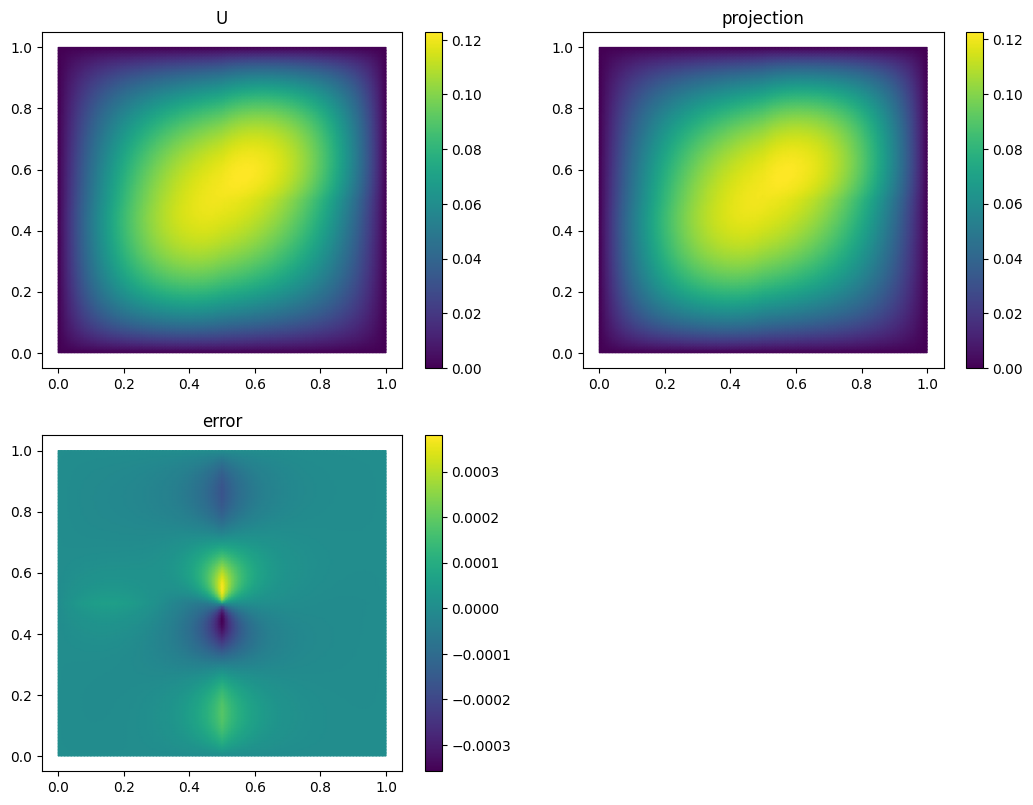

In [17]:
U_test = fom.solve(p.parameter_space.sample_randomly())
coeffs = U_test.inner(basis)
U_test_proj = basis.lincomb(coeffs)
fom.visualize((U_test, U_test_proj, U_test-U_test_proj),
              legend=('U', 'projection', 'error'),
              separate_colorbars=True)

Let's also compute the norm of the error:

In [18]:
(U_test - U_test_proj).norm().item() / U_test.norm().item()

0.000745499367827598

### Assembling the reduced system matrix

In order to compute a reduced solution, we need to choose a reduced basis $\psi_{1}, \ldots, \psi_{N}$ of $V_N$ and assemble the reduced system matrix $A_{N}(\mu) \in \mathbb{R}^{N\times N}$ and right-hand side vector $\underline{\ell}_N \in \mathbb{R}^N$ given by

$$
    A_N(\mu)_{j,i} := a(\psi_i, \psi_j; \mu) \qquad
    \underline{\ell}_{N,j} := \ell(\psi_j).
$$

Expanding each basis vector $\psi_i$ w.r.t. the finite-element basis $\varphi_{h,i}$,

$$
    \psi_i = \sum_{k=1}^N \underline{\psi}_{i,k} \varphi_{h,k},
$$

we get

$$
    A_N(\mu)_{i,j} = \underline{\psi}_i^{\operatorname{T}} \cdot A(\mu) \cdot \underline{\psi}_j.
$$

Thus, we could compute $A_N(\mu)$ in pyMOR using `W = fom.operator.apply(basis, mu=mu)` (multiplication from the right) and then using `basis.inner(W)` to multiply the basis from the left. We can use the `apply2` method as a (potentially more efficient) shorthand:

In [19]:
mu = p.parameter_space.sample_randomly()
A_N = fom.operator.apply2(basis, basis, mu=mu)
A_N.shape

(10, 10)

Note that, contrary to the finite-element system matrix $A(\mu)$, the reduced matrix $A_N(\mu)$ is a dense but small matrix.

### Assembling the reduced right-hand side

For the right-hand side we have

$$
    \underline{\ell}_{N,j} = \underline{\psi}_j^{\operatorname{T}} \cdot \underline{\ell},
$$

which we compute using `inner`:

In [20]:
l_N = basis.inner(fom.rhs.as_vector())
l_N.shape

(10, 1)

### Solving the reduced system

Finally, writing

$$
    u_N(\mu) = \sum_{i=1}^N \underline{u}_N(\mu)_i \cdot \psi_i
$$

we have

$$
    A_N(\mu) \cdot \underline{u}_N(\mu) = \underline{\ell}_N
$$

So, let's solve the linear system and compare the reduced solution to the FOM solution:

01:16:21 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.8490338212556809, 0.8242879217471216, 0.44873054112715705, 0.35949529353721976], input: } ...


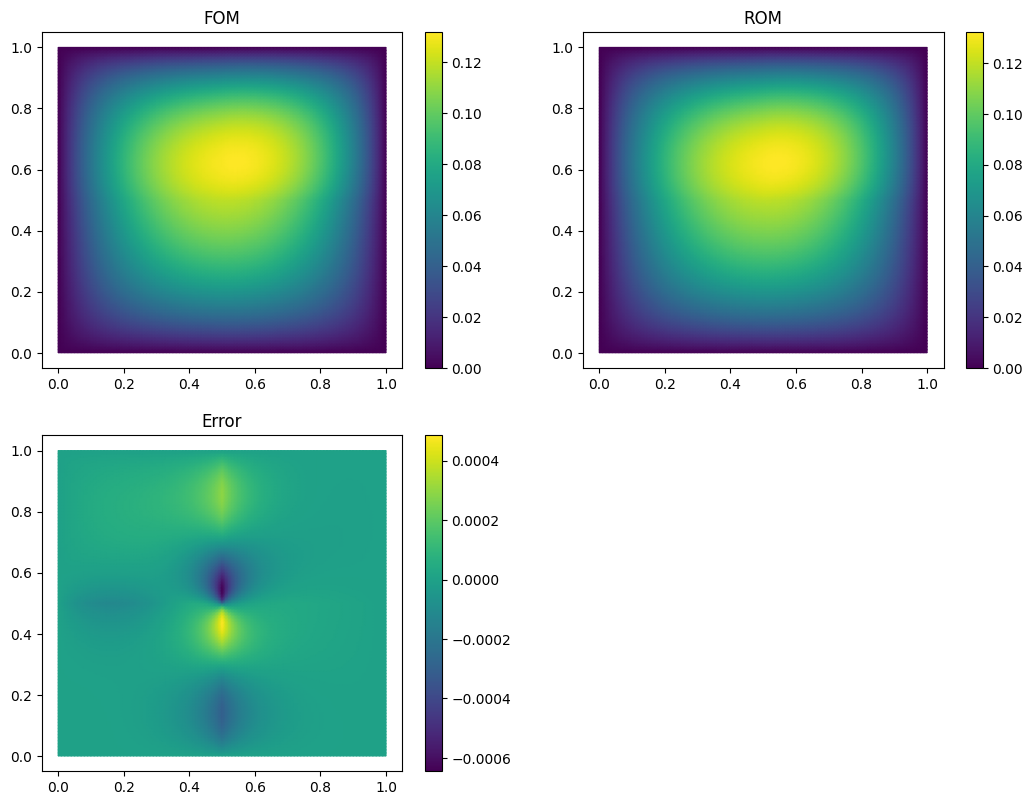

In [21]:
import numpy as np
u_N = np.linalg.solve(A_N, l_N)
U_N = basis.lincomb(u_N.ravel())
U = fom.solve(mu)
fom.visualize((U, U_N, U-U_N),
              legend=('FOM', 'ROM', 'Error'),
              separate_colorbars=True)

### Automatic structure-preserving operator projection

For each new parameter $\mu$ we want to solve the ROM for, we have to assemble a new $A_N(\mu)$, which requires $\mathcal{O}(N^2)$ high-dimensional operations. This can significantly diminish the efficiency of our ROM. However, we can avoid this issue by exploiting the parameter separability of $A(\mu)$,

$$
    A(\mu) = \sum_{q=1}^Q \theta_q(\mu) \cdot A_q,
$$

which is inherited by $A_N(\mu)$:

$$
    A_N(\mu) = \sum_{q=1}^Q \theta_q(\mu) \cdot A_{N,q},
$$
where $(A_{N,q})_{i,j} = \underline{\psi}_i^{\operatorname{T}} \cdot A_q \cdot \underline{\psi}_j$.

Thus, we have to project all operators in `fom.operator.operators` individually and then later form a linear combination of these matrices.

This is getting tedious, so we let pyMOR do the work for us:

In [22]:
op_N = project(fom.operator, basis, basis)
op_N

LincombOperator(
    (NumpyMatrixOperator(<10x10 dense>),
     NumpyMatrixOperator(<10x10 dense>),
     NumpyMatrixOperator(<10x10 dense>),
     NumpyMatrixOperator(<10x10 dense>),
     NumpyMatrixOperator(<10x10 dense>)),
    (1.0,
     ProjectionParameterFunctional('diffusion', size=4, index=0, name='diffusion_0_0'),
     ProjectionParameterFunctional('diffusion', size=4, index=1, name='diffusion_1_0'),
     ProjectionParameterFunctional('diffusion', size=4, index=2, name='diffusion_0_1'),
     ProjectionParameterFunctional('diffusion', size=4, index=3, name='diffusion_1_1')))

Similarly, we can project the right-hand side:

In [23]:
rhs_N = project(fom.rhs, basis, None)
rhs_N

NumpyMatrixOperator(<10x1 dense>)

Now, we could assemble a matrix operator from `op_N` for a specific `mu` using the `assemble` method:

In [24]:
op_N_mu = op_N.assemble(mu)
op_N_mu

NumpyMatrixOperator(<10x10 dense>)

Then, we can extract it's system matrix:

In [25]:
op_N_mu.matrix.shape

(10, 10)

From that, we can proceed as before. However, it is more convenient, to use the operator's `apply_inverse` method to invoke an (`Operator`-dependent) linear solver with a given input `VectorArray` as right-hand side:

In [26]:
u_N_new = op_N.apply_inverse(rhs_N.as_vector(), mu=mu)
u_N_new

NumpyVectorArray(
    NumpyVectorSpace(10),
    [[ 9.79462092 -0.06991433 -0.4354128   2.02776227  0.01176885 -0.09690665
      -0.15651242  0.05538019 -0.15792214  0.0191176 ]],
    _len=1)

Note that the result is a `VectorArray`. For `NumpyVectorArray` and some other `VectorArray` types, we can extract the internal data using the `to_numpy` method. We use it to check whether we arrived at the same solution:

In [27]:
np.linalg.norm(u_N.ravel() - u_N_new.to_numpy().ravel())

0.0

### Projecting the entire Model (pyMOR: [`StationaryRBReductor`](https://docs.pymor.org/main/autoapi/pymor/reductors/basic/index.html#pymor.reductors.basic.StationaryRBReductor))

In pyMOR, ROMs are built using a `Reductor` which appropriately projects all of the `Models` operators and returns a reduced `Model` comprised of the projected `Operators`. Let's pick the most basic `Reductor`
available for a `StationaryModel`:

In [28]:
reductor = StationaryRBReductor(fom, basis)

Every reductor has a `reduce` method, which builds the ROM:

In [29]:
rom = reductor.reduce()

01:29:58 StationaryRBReductor: Operator projection ...
01:29:58 StationaryRBReductor: Building ROM ...


Let's compare the structure of the FOM and of the ROM

In [30]:
fom

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<20201x20201 sparse, 400 nnz>, source_id='STATE', range_id='STATE', name='boundary_part'),
         NumpyMatrixOperator(<20201x20201 sparse, 24801 nnz>, source_id='STATE', range_id='STATE', name='diffusion_0'),
         NumpyMatrixOperator(<20201x20201 sparse, 24801 nnz>, source_id='STATE', range_id='STATE', name='diffusion_1'),
         NumpyMatrixOperator(<20201x20201 sparse, 24801 nnz>, source_id='STATE', range_id='STATE', name='diffusion_2'),
         NumpyMatrixOperator(<20201x20201 sparse, 24801 nnz>, source_id='STATE', range_id='STATE', name='diffusion_3')),
        (1.0,
         ProjectionParameterFunctional('diffusion', size=4, index=0, name='diffusion_0_0'),
         ProjectionParameterFunctional('diffusion', size=4, index=1, name='diffusion_1_0'),
         ProjectionParameterFunctional('diffusion', size=4, index=2, name='diffusion_0_1'),
         ProjectionParameterFunctional('diffusion', size=4, index=3, na

In [31]:
rom

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<10x10 dense>),
         NumpyMatrixOperator(<10x10 dense>),
         NumpyMatrixOperator(<10x10 dense>),
         NumpyMatrixOperator(<10x10 dense>),
         NumpyMatrixOperator(<10x10 dense>)),
        (1.0,
         ProjectionParameterFunctional('diffusion', size=4, index=0, name='diffusion_0_0'),
         ProjectionParameterFunctional('diffusion', size=4, index=1, name='diffusion_1_0'),
         ProjectionParameterFunctional('diffusion', size=4, index=2, name='diffusion_0_1'),
         ProjectionParameterFunctional('diffusion', size=4, index=3, name='diffusion_1_1'))),
    NumpyMatrixOperator(<10x1 dense>),
    output_functional=ZeroOperator(NumpyVectorSpace(0), NumpyVectorSpace(10)),
    products={h1: NumpyMatrixOperator(<10x10 dense>),
              h1_semi: NumpyMatrixOperator(<10x10 dense>),
              l2: NumpyMatrixOperator(<10x10 dense>),
              h1_0: NumpyMatrixOperator(<10x10 dense>),
           

### Solving the ROM

To solve the ROM, we just use `solve` again,

In [32]:
u_rom = rom.solve(mu)

to get the reduced coefficients:

In [33]:
u_rom

NumpyVectorArray(
    NumpyVectorSpace(10),
    [[ 9.79462092 -0.06991433 -0.4354128   2.02776227  0.01176885 -0.09690665
      -0.15651242  0.05538019 -0.15792214  0.0191176 ]],
    _len=1)

It is the same coefficient vector we have computed before:

In [34]:
(u_rom - u_N_new).norm()

array([0.])

A high-dimensional representation is obtained from the `reductor`:

In [35]:
U_rom = reductor.reconstruct(u_rom)

### Computing the MOR error

Let's compute the error again:

In [36]:
U = fom.solve(mu)
ERR = U - U_rom
ERR.norm() / U.norm()

01:32:06 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.8490338212556809, 0.8242879217471216, 0.44873054112715705, 0.35949529353721976], input: } ...


array([0.00117329])

and look at it:

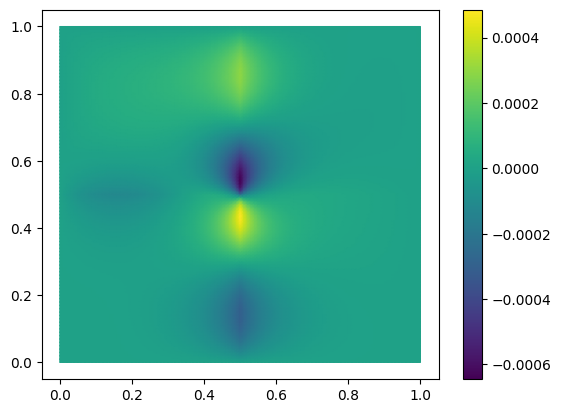

In [37]:
fom.visualize(ERR)

## Proper orthogonal decomposition (pyMOR: [`pod`](https://docs.pymor.org/main/autoapi/pymor/algorithms/pod/index.html#module-pymor.algorithms.pod))

A popular method to create a reduced basis out of snapshot data is the so-called
Proper Orthogonal Decomposition (POD) which can be seen as a non-centered version of
Principal Component Analysis (PCA). First we build a snapshot matrix

$$
A :=
\begin{bmatrix}
\vdots & \vdots & \cdots & \vdots \\
u(\mu_1) & u(\mu_2) & \cdots & u(\mu_K)\\
\vdots & \vdots & \cdots & \vdots
\end{bmatrix},
$$

where $K$ denotes the total number of solution snapshots. Then we compute the singular value decomposition (SVD) of $A$ as

$$
A = U \Sigma V^T,
$$

where $\Sigma$ is an $r \times r$-diagonal matrix, $U$ is an $n \times r$-matrix
and $V$ is an $K \times r$-matrix (both having pairwise orthonormal columns). Here, $r$ is the rank of $A$.
The diagonal entries $\sigma_i$ of $\Sigma$ are the singular values of $A$, which are
assumed to be monotonically decreasing.

If we let $V_N$ be the span of the first $N$ left-singular vectors of $A$, then
the following error identity holds:

$$
\sum_{k = 1}^K \inf_{v \in V_N} \|u(\mu_k) - v\|^2 =\,
\min_{\substack{W_N \subseteq V\\ \operatorname{dim}(W_N) \leq N}} \sum_{k = 1}^K \inf_{v \in W_N} \|u(\mu_k) - v\|^2 =
\sum_{i = N+1}^{r} \sigma^2
$$

Thus, the linear spaces produced by the POD are actually optimal, they minimize the $\ell^2$-sum of all best-approximation errors.
So in the mean squared average, the POD spaces are optimal, but there might be parameter values
for which the best-approximation error is quite large.

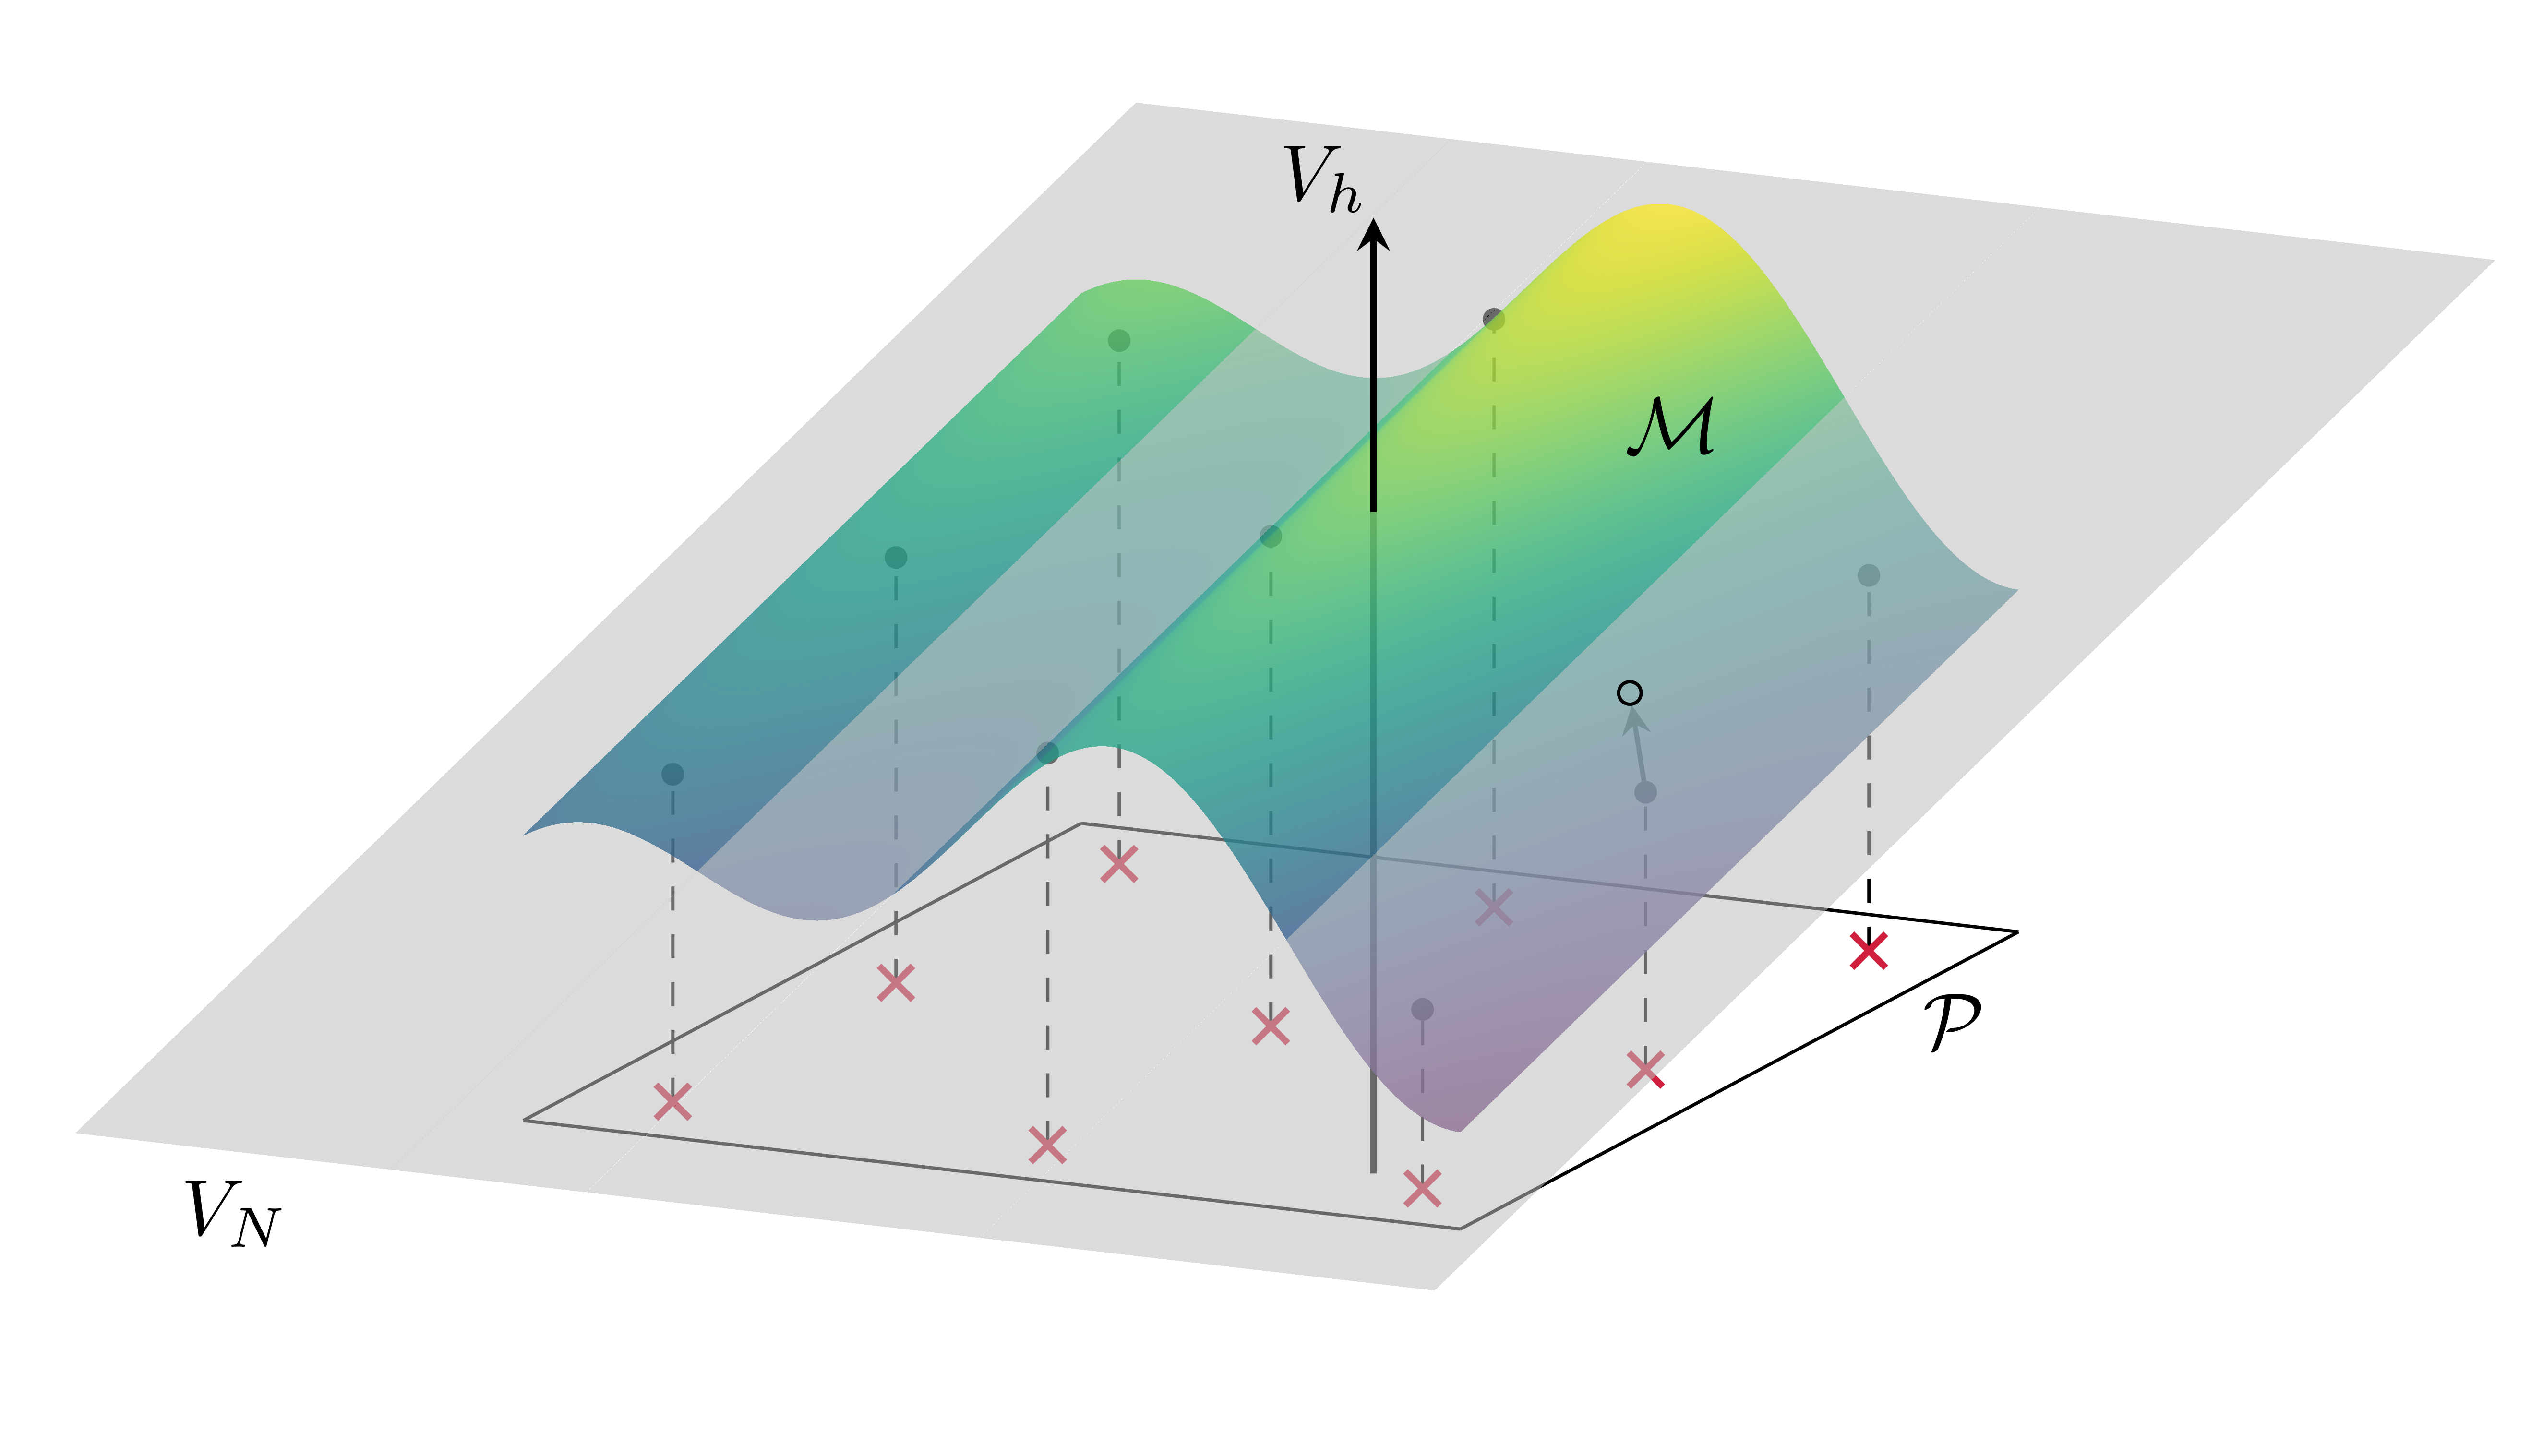

In [3]:
Image(filename="figures/manifold_pod_standalone.png", width=400)

Let us define a larger set of training parameters and compute corresponding solutions:

In [47]:
training_set_pod = p.parameter_space.sample_randomly(50)
training_data = fom.solution_space.empty()
for mu in training_set_pod:
    training_data.append(fom.solve(mu))

02:29:19 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.5015406480166277, 0.4429191034868343, 0.3713608802330889, 0.6672543338069996], input: } ...
02:29:19 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.42563134949805137, 0.1788849273844909, 0.2062053119084638, 0.965707898094563], input: } ...
02:29:19 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.9177226216368464, 0.7297364204296746, 0.3392829653135676, 0.9722587396129515], input: } ...
02:29:20 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.8008758135692151, 0.7452011702430961, 0.5044253519294098, 0.3450174056606431], input: } ...
02:29:20 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.18675186593814935, 0.9123421568894575, 0.51019866085025, 0.2821270283157073], input: } ...
02:29:20 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion

The POD in pyMOR can be called as follows, selecting the 10 dominand modes:

In [48]:
pod_basis, pod_singular_values = pod(training_data, modes=10)

02:31:30 pod: Computing SVD ...
02:31:30 |   method_of_snapshots: Computing Gramian (50 vectors) ...
02:31:30 |   method_of_snapshots: Computing eigenvalue decomposition ...
02:31:30 |   method_of_snapshots: Computing left-singular vectors (10 vectors) ...
02:31:30 pod: Checking orthonormality ...


We now reduce using the basis obtained via POD

In [49]:
pod_reductor = StationaryRBReductor(fom, pod_basis)
pod_rom = pod_reductor.reduce()

02:31:48 StationaryRBReductor: Operator projection ...
02:31:48 StationaryRBReductor: Building ROM ...


and compute the error as

In [50]:
u_pod_rom = pod_rom.solve(mu)
U_pod_rom = pod_reductor.reconstruct(u_pod_rom)
U = fom.solve(mu)
ERR_pod = U - U_pod_rom
ERR_pod.norm() / U.norm()

02:31:54 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.5713776538458735, 0.1915047126133444, 0.8501126984097037, 0.14676567981859384], input: } ...


array([0.00136084])

### Is it actually faster?

Finally, we check if our ROM is really any faster than the FOM:

In [51]:
from time import perf_counter
mus = p.parameter_space.sample_randomly(10)
tic = perf_counter()
for mu in mus:
    fom.solve(mu)
t_fom = perf_counter() - tic
tic = perf_counter()
for mu in mus:
    rom.solve(mu)
t_rom = perf_counter() - tic
print(f'Speedup: {t_fom/t_rom}')

02:33:23 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.9323576821162559, 0.18920182742188796, 0.8592174564379774, 0.9123878295348554], input: } ...
02:33:23 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.9816136125279334, 0.8218232922462342, 0.8015297866941961, 0.6782349483959929], input: } ...
02:33:23 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.8010967191203161, 0.22109698757183238, 0.5824612323528736, 0.562800583171373], input: } ...
02:33:23 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.8718149297103018, 0.5165194290341643, 0.4465805464903182, 0.675606944113399], input: } ...
02:33:23 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.33981698575076147, 0.2257915698585612, 0.5300895466213712, 0.4752004317353965], input: } ...
02:33:23 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusi

Speedup: 340.3833688111886


## Certified Reduced Basis Method

### Error estimator
Model order reduction introduces an additional approximation error which we need to control in order to be able to use a ROM as a reliable surrogate for a given FOM. While Céa's lemma provides a rigorous a priori bound, this error bound is not computable in general. Instead, we use a residual-based a posteriori error estimator. As in a posteriori theory for finite-element methods, we have:

$$
    \|\nabla u_h(\mu) - \nabla u_N(\mu)\|_{L^2(\Omega)}
    \leq \frac{1}{\mu_{min}} \sup_{v_h\in V_h} \frac{|\ell(v_h) - a(u_N(\mu), v_h; \mu)|}{\|\nabla v_h\|_{L^2(\Omega)}}.
$$

For this estimate to hold, it is crucial that we use the right norms. I.e., instead of the Euclidean norm of the coefficient vectors, which we have used so far, we need to use the $H^1$-seminorm. 

The inner product matrix of the $H^1$-seminorm is automatically assembled by pyMOR's builtin discretizer and available as `fom.h1_0_semi_product`. We can pass it as the `product`-argument to methods like `norm`, `inner` or `gram_schmidt` to perform these operations w.r.t. the correct inner product/norm. Further, we need a lower bound for the coercivity constant of $a(\cdot, \cdot; \mu)$.

Using this information, we can replace `StationaryRBReductor` by `CoerciveRBReductor`, which will add a reduction-error estimator to our ROM:

In [38]:
basis = gram_schmidt(snapshots, product=fom.h1_0_semi_product)
reductor = CoerciveRBReductor(
   fom, basis,
   product=fom.h1_0_semi_product,
   coercivity_estimator=ExpressionParameterFunctional('min(diffusion)', fom.parameters)
)
rom = reductor.reduce()

01:35:13 gram_schmidt: Orthonormalizing vector 1 again
01:35:13 gram_schmidt: Orthonormalizing vector 2 again
01:35:13 gram_schmidt: Orthonormalizing vector 3 again
01:35:13 gram_schmidt: Orthonormalizing vector 4 again
01:35:13 gram_schmidt: Orthonormalizing vector 5 again
01:35:13 gram_schmidt: Orthonormalizing vector 6 again
01:35:13 gram_schmidt: Orthonormalizing vector 7 again
01:35:13 gram_schmidt: Orthonormalizing vector 8 again
01:35:13 gram_schmidt: Orthonormalizing vector 9 again
01:35:13 CoerciveRBReductor: Operator projection ...
01:35:13 CoerciveRBReductor: Assembling error estimator ...
01:35:13 |   ResidualReductor: Estimating residual range ...
01:35:13 |   |   estimate_image_hierarchical: Estimating image for basis vector -1 ...
01:35:13 |   |   estimate_image_hierarchical: Orthonormalizing ...
01:35:13 |   |   estimate_image_hierarchical: Estimating image for basis vector 0 ...
01:35:13 |   |   estimate_image_hierarchical: Orthonormalizing ...
01:35:13 |   |   |   gra

We won't go into details here, but an 'offline-online decomposition' of the error estimator is possible similar to what we did for the projection of the system operator:

In [39]:
rom.error_estimator.residual

ResidualOperator(
    LincombOperator(
        (NumpyMatrixOperator(<40x10 dense>),
         NumpyMatrixOperator(<40x10 dense>),
         NumpyMatrixOperator(<40x10 dense>),
         NumpyMatrixOperator(<40x10 dense>),
         NumpyMatrixOperator(<40x10 dense>)),
        (1.0,
         ProjectionParameterFunctional('diffusion', size=4, index=0, name='diffusion_0_0'),
         ProjectionParameterFunctional('diffusion', size=4, index=1, name='diffusion_1_0'),
         ProjectionParameterFunctional('diffusion', size=4, index=2, name='diffusion_0_1'),
         ProjectionParameterFunctional('diffusion', size=4, index=3, name='diffusion_1_1'))),
    NumpyMatrixOperator(<40x1 dense>))

Let's check if the estimator works:

In [40]:
U = fom.solve(mu)
u_N = rom.solve(mu)
est = rom.estimate_error(mu).item()
err = (U - reductor.reconstruct(u_N)).norm(product=fom.h1_0_semi_product).item()
print(f'error: {err}, estimate: {est}')

01:35:42 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.8490338212556809, 0.8242879217471216, 0.44873054112715705, 0.35949529353721976], input: } ...


error: 0.0017592771030094582, estimate: 0.0030500290647576494


### Greedy basis generation (pyMOR: [`rb_greedy`](https://docs.pymor.org/main/autoapi/pymor/algorithms/greedy/index.html#pymor.algorithms.greedy.rb_greedy))

So far, we have built the reduced space $V_N$ by just randomly picking snapshot parameters. A theoretically well-founded approach which leads to quasi-optimal approximation spaces it the so-called *weak greedy algorithm*. In the weak greedy algorithm, $V_N$ is constructed iteratively by enlarging $V_N$ by an element $u_h(\mu_{N+1})$ such that

$$ \inf_{v_N \in V_N} \|\nabla u_h(\mu_{N+1}) - \nabla v_N\|_{L^2(\Omega)}
\geq C \cdot \sup_{\mu \in \mathcal{P}}\inf_{v_N \in V_N} \|\nabla u_h(\mu) - \nabla v_N\|_{L^2(\Omega)}, $$

for some fixed constant $0 < C \leq 1$.

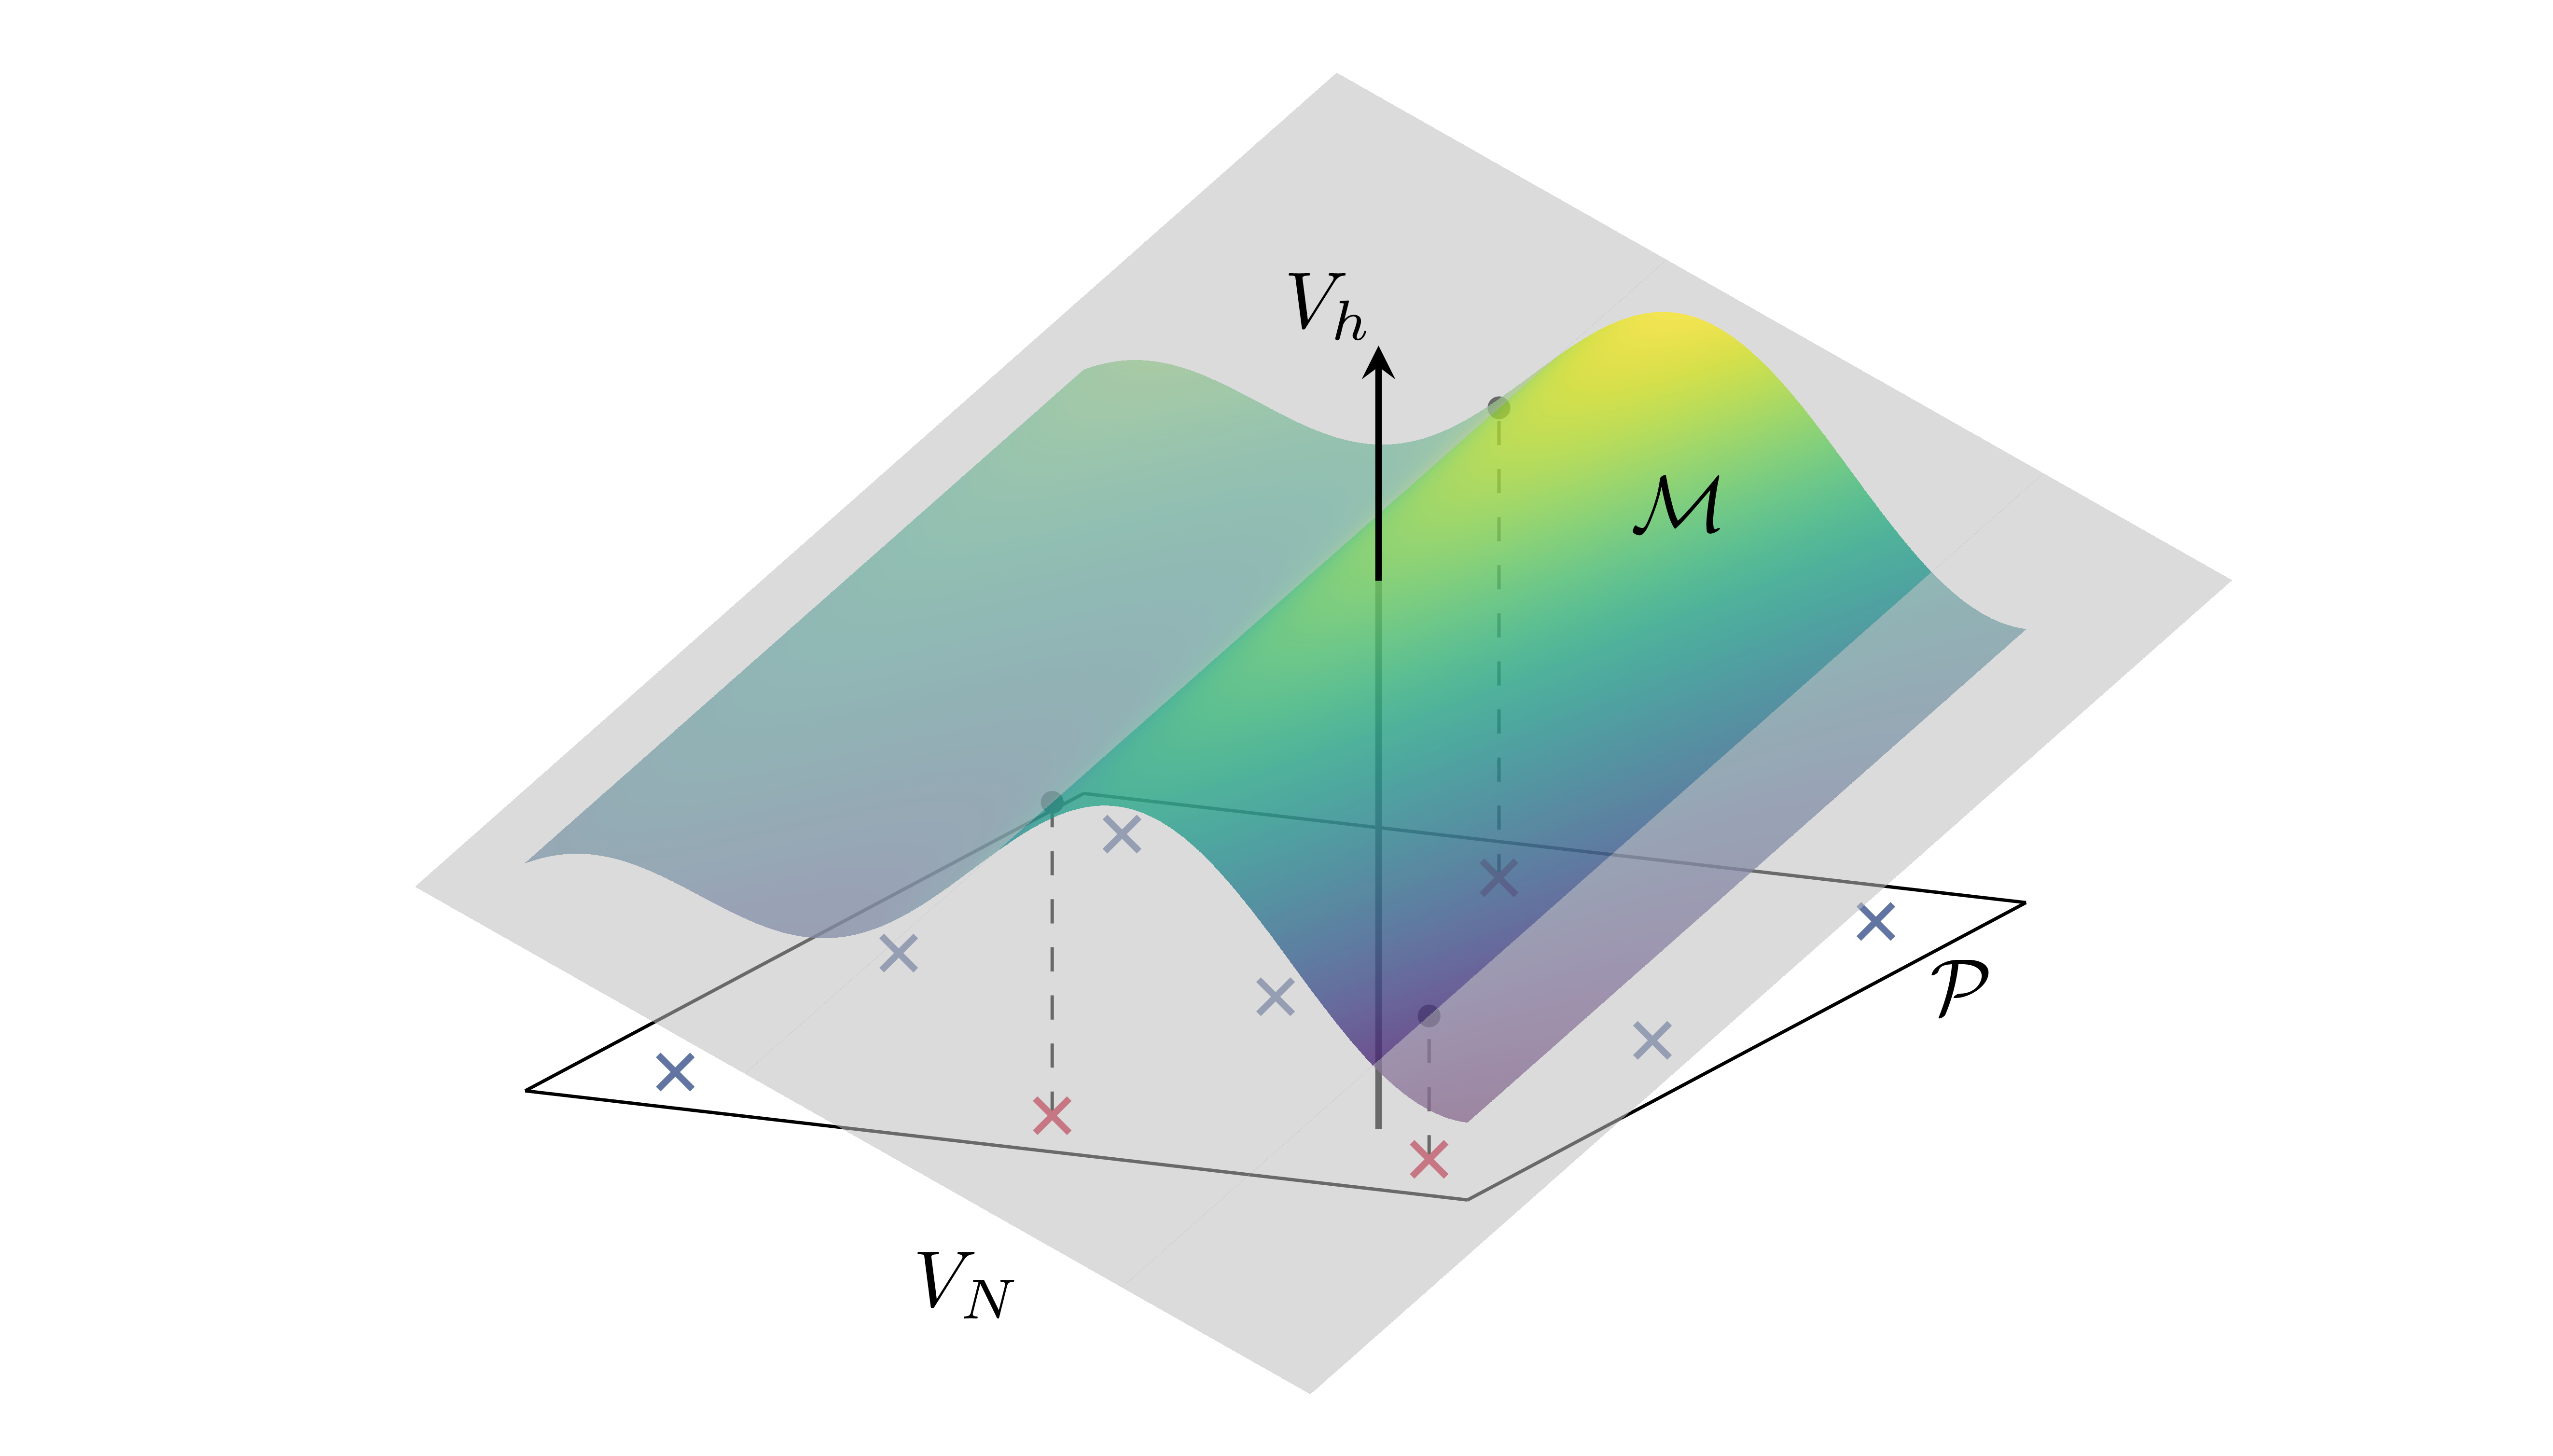

In [4]:
Image(filename="figures/manifold_greedy_standalone.png", width=400)

In RB methods, we find such a $\mu_{N+1}$ by picking the parameter for which the estimated reduction error is maximized.

In order to make this maximization procedure computationally feasible, the infinite set $\mathcal{P}$ is replaced by a finite subset of training parameters:

In [41]:
training_set = p.parameter_space.sample_uniformly(4)
len(training_set)

256

Given this training set, we can use `rb_greedy` to compute $V_N$. In order to start with an empty basis, we create a new reductor that, by default, is initialized with an empty basis:

In [42]:
reductor = CoerciveRBReductor(
   fom,
   product=fom.h1_0_semi_product,
   coercivity_estimator=ExpressionParameterFunctional('min(diffusion)', fom.parameters)
)
greedy_data = rb_greedy(fom, reductor, training_set, max_extensions=20)
print(greedy_data.keys())
rom = greedy_data['rom']

01:44:36 weak_greedy: Started greedy search on training set of size 256.
01:44:36 weak_greedy: Estimating errors ...
01:44:36 |   RBSurrogate: Reducing ...
01:44:36 |   |   CoerciveRBReductor: Operator projection ...
01:44:36 |   |   CoerciveRBReductor: Assembling error estimator ...
01:44:36 |   |   |   ResidualReductor: Estimating residual range ...
01:44:36 |   |   |   |   estimate_image_hierarchical: Estimating image for basis vector -1 ...
01:44:36 |   |   |   |   estimate_image_hierarchical: Orthonormalizing ...
01:44:36 |   |   |   ResidualReductor: Projecting residual operator ...
01:44:36 |   |   CoerciveRBReductor: Building ROM ...
01:44:36 weak_greedy: Maximum error after 0 extensions: 1.8745731821515639 (mu = {diffusion: [0.1, 0.1, 0.1, 0.1]})
01:44:36 weak_greedy: Extending surrogate for mu = {diffusion: [0.1, 0.1, 0.1, 0.1]} ...
01:44:36 |   RBSurrogate: Computing solution snapshot for mu = {diffusion: [0.1, 0.1, 0.1, 0.1]} ...
01:44:36 |   |   StationaryModel: Computing 

dict_keys(['max_errs', 'max_err_mus', 'extensions', 'time', 'rom'])


### Testing the ROM

Let's compute the error again:

In [43]:
mu = p.parameter_space.sample_randomly()
U = fom.solve(mu)
u_rom = rom.solve(mu)
ERR = U - reductor.reconstruct(u_rom)
ERR.norm(fom.h1_0_semi_product)

01:46:01 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.7142459535774779, 0.22577723524837884, 0.2799173822275975, 0.10662604277590497], input: } ...


array([1.62129736e-07])

and compare it with the estimated error:

In [44]:
rom.estimate_error(mu)

array([4.48591137e-07])

In [45]:
rom

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<20x20 dense>),
         NumpyMatrixOperator(<20x20 dense>),
         NumpyMatrixOperator(<20x20 dense>),
         NumpyMatrixOperator(<20x20 dense>),
         NumpyMatrixOperator(<20x20 dense>)),
        (1.0,
         ProjectionParameterFunctional('diffusion', size=4, index=0, name='diffusion_0_0'),
         ProjectionParameterFunctional('diffusion', size=4, index=1, name='diffusion_1_0'),
         ProjectionParameterFunctional('diffusion', size=4, index=2, name='diffusion_0_1'),
         ProjectionParameterFunctional('diffusion', size=4, index=3, name='diffusion_1_1'))),
    NumpyMatrixOperator(<20x1 dense>),
    output_functional=ZeroOperator(NumpyVectorSpace(0), NumpyVectorSpace(20)),
    products={h1: NumpyMatrixOperator(<20x20 dense>),
              h1_semi: NumpyMatrixOperator(<20x20 dense>),
              l2: NumpyMatrixOperator(<20x20 dense>),
              h1_0: NumpyMatrixOperator(<20x20 dense>),
           

### Is it actually faster?

Finally, we check if our ROM is really any faster than the FOM:

In [46]:
from time import perf_counter
mus = p.parameter_space.sample_randomly(10)
tic = perf_counter()
for mu in mus:
    fom.solve(mu)
t_fom = perf_counter() - tic
tic = perf_counter()
for mu in mus:
    rom.solve(mu)
t_rom = perf_counter() - tic
print(f'Speedup: {t_fom/t_rom}')

01:52:00 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.8082319397519245, 0.6983657709328289, 0.7346488407637016, 0.8026561279197711], input: } ...
01:52:00 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.5130241979845059, 0.6118670763576044, 0.22581729831489172, 0.2030770661823761], input: } ...
01:52:00 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.7015626656114244, 0.5239865855288193, 0.60871249583307, 0.7884989716744231], input: } ...
01:52:00 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.6712464880005318, 0.5982214605921963, 0.6032864446708722, 0.373555088256351], input: } ...
01:52:01 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.12773605111114547, 0.49304565030912617, 0.2931262055375763, 0.4676757793521725], input: } ...
01:52:01 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusio

Speedup: 316.28071261849163


## Basis generation: Summary
----------------------------

| Method | POD | Weak Greedy |
|--------|-----|-------------|
| **Computational effort** | Precomputes full snapshot set | Computes snapshots only for selected parameters |
| **Reduction goal** | Aims at reducing $L^2(\mathcal{P})$-error | Aims at reducing $L^\infty(\mathcal{P})$-error |
| **Requirements** | Requires only snapshot data | Requires reliable and efficient error estimator |
| **Criterion for reduced basis size** | Sum of truncated squared singular values | Maximum estimated error over training set |
| **Theoretical result** | $L^2$-best approximation over training set shown | Error decay shown if Kolmogorov-$N$ width decays algebraically or exponentially and error estimator is efficient |

----------------------------

## Neural networks for model order reduction (pyMOR: [`NeuralNetworkReductor`](https://docs.pymor.org/main/autoapi/pymor/reductors/neural_network/index.html#pymor.reductors.neural_network.NeuralNetworkReductor))

### Learning the map from parameters to reduced coefficients

**Key observation:** Reduced coefficients $\underline{u}_N(\mu)\in\mathbb{R}^N$ are sufficient to determine reduced solution.

**Main idea:** Learn these coefficients as a function of the parameter $\mu\in\mathcal{P}$ using machine learning, for instance neural networks, kernel methods, Gaussian process regression, etc.

**Training data:** Pairs of parameters and reduced coefficients $(\mu_1,\underline{u}_N(\mu_1)),\dots,(\mu_{k},\underline{u}_N(\mu_{k}))$.

*(To be more precise: Learn coefficients of orthogonal projection onto reduced space instead of Galerkin projection.)*

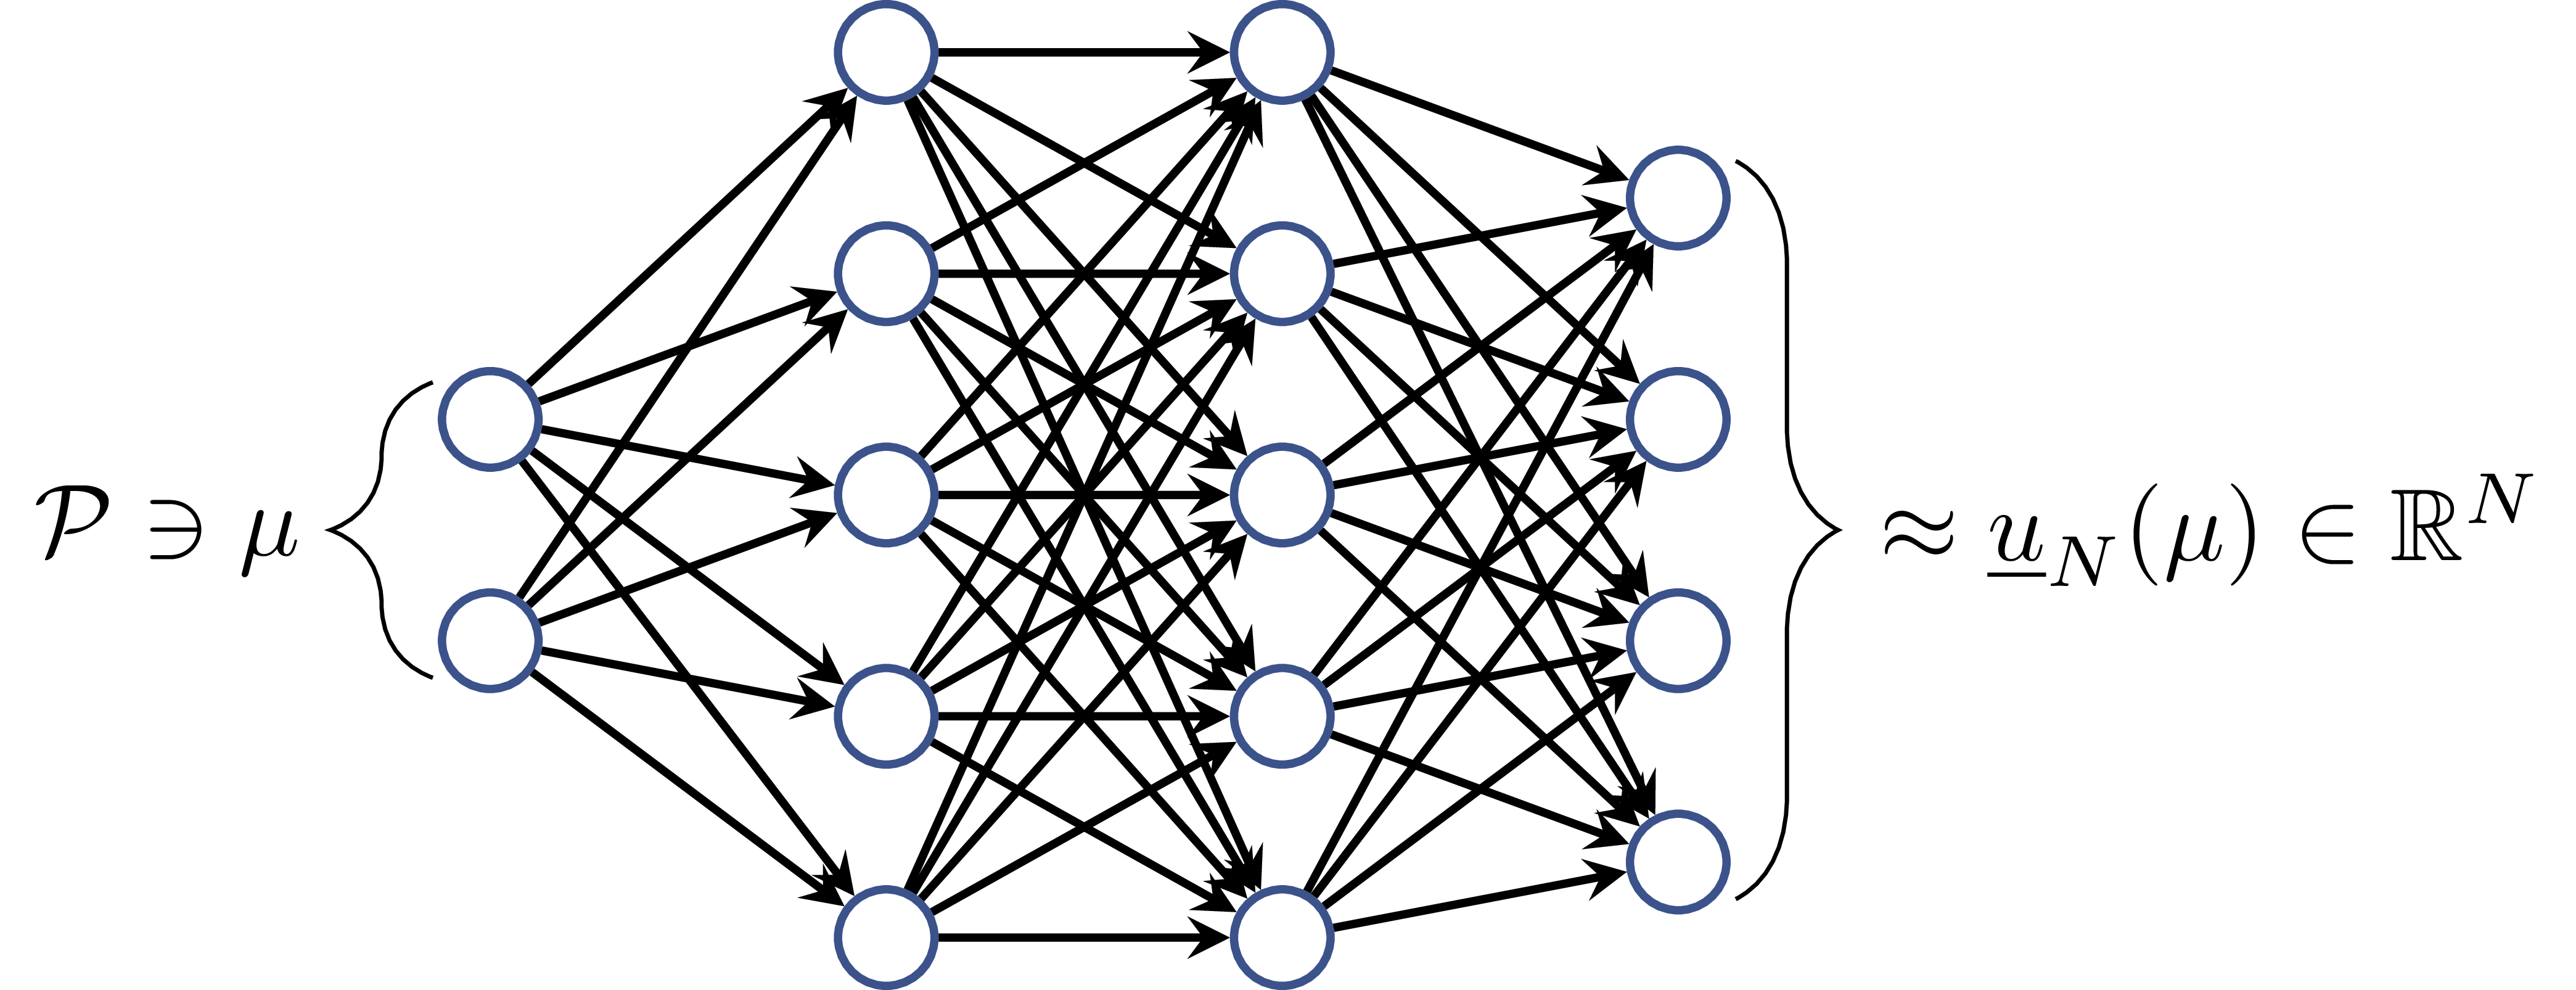

In [5]:
Image(filename="figures/neural_network.png", width=400)

**Advantages:**
- Non-intrusive method, i.e. no knowledge about the underlying system is required.
- No (dense) linear system has to be solved during the online phase.
- Also applicable to nonlinear problems.

**Potential drawbacks:**
- Does not take physics into account.
- Typically no error estimates available.
- Requires training of machine learning and (depending on the problem) a large amount of training data.

In [52]:
from pymor.reductors.neural_network import NeuralNetworkReductor
import torch.optim as optim
nn_reductor = NeuralNetworkReductor(fom, training_set_pod, basis_size=10, ann_mse=None)
nn_rom = nn_reductor.reduce()

02:45:05 NeuralNetworkReductor: Computing training snapshots ...
02:45:05 |   StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.5015406480166277, 0.4429191034868343, 0.3713608802330889, 0.6672543338069996], input: } ...
02:45:05 |   StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.42563134949805137, 0.1788849273844909, 0.2062053119084638, 0.965707898094563], input: } ...
02:45:06 |   StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.9177226216368464, 0.7297364204296746, 0.3392829653135676, 0.9722587396129515], input: } ...
02:45:06 |   StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.8008758135692151, 0.7452011702430961, 0.5044253519294098, 0.3450174056606431], input: } ...
02:45:06 |   StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.18675186593814935, 0.9123421568894575, 0.51019866085025, 0.2821270283157073], input: } ...
0

In [53]:
mu = p.parameter_space.sample_randomly()
U = fom.solve(mu)
u_nn_rom = nn_rom.solve(mu)
ERR = U - nn_reductor.reconstruct(u_nn_rom)
ERR.norm()

02:47:00 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.786278932363587, 0.34348144681915815, 0.4277728159948486, 0.38299598218383657], input: } ...
02:47:00 NeuralNetworkModel: Computing solution of ThermalBlock([2, 2])_CG_reduced for {diffusion: [0.786278932363587, 0.34348144681915815, 0.4277728159948486, 0.38299598218383657], input: } ...


array([0.08788913])

In [54]:
from time import perf_counter
mus = p.parameter_space.sample_randomly(10)
tic = perf_counter()
for mu in mus:
    fom.solve(mu)
t_fom = perf_counter() - tic
tic = perf_counter()
for mu in mus:
    nn_rom.solve(mu)
t_rom = perf_counter() - tic
print(f'Speedup: {t_fom/t_rom}')

02:47:00 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.2418504837624997, 0.2330050352879725, 0.9425147170381696, 0.49411363347887793], input: } ...
02:47:00 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.4449878404996689, 0.7567171378096401, 0.59769375872761, 0.942525988154616], input: } ...
02:47:01 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.802271344518453, 0.5314326077120863, 0.43872352613274357, 0.9879683904318898], input: } ...
02:47:01 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.7459842124032792, 0.956075194003457, 0.20663071949533723, 0.8654803112717043], input: } ...
02:47:01 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion: [0.6733664955920868, 0.20972951050160132, 0.6294321999722986, 0.7174867285949039], input: } ...
02:47:01 StationaryModel: Computing solution of ThermalBlock([2, 2])_CG for {diffusion

Speedup: 57.08923541483631


#### Variants

- `NeuralNetworkInstationaryReductor`: Instationary problems, treats time as additional input to the neural network
- `NeuralNetworkStatefreeOutputReductor`: Approximates only the output and works without access to the state
- `NeuralNetworkInstationaryStatefreeOutputReductor`: Similar to `NeuralNetworkStatefreeOutputReductor` but for instationary problems
- `NeuralNetworkLSTMInstationaryReductor`: Uses long short-term memory neural networks for instationary problems
- `NeuralNetworkLSTMInstationaryStatefreeOutputReductor`: Similar to `NeuralNetworkLSTMInstationaryReductor` but approximates only the output